## Declaring libraries
Note: activate the Conda Instance to run PyTorch or similar

In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Path of the project
Note: Consider this path as the address where the files '2019-04-01_00h_UTC_PMUID01.txt' and '2019-04-01_00h_UTC_PMUID02.txt' are saved.

In [2]:
cd /home/lut/Desktop/slicing_powersystems

/home/lut/Desktop/slicing_powersystems


## Importing micro grid dataset
Note: The *.txt information should be formated as numpy.loadtxt() function requires.

In [3]:
import numpy
data1 = numpy.loadtxt('2019-04-01_00h_UTC_PMUID01.txt')
data2 = numpy.loadtxt('2019-04-01_00h_UTC_PMUID02.txt')

## Saving and plotting dataset information in specific variables

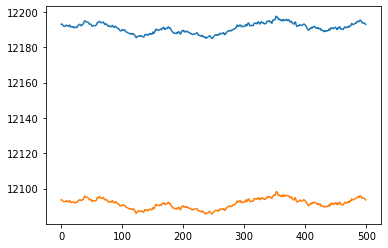

In [4]:
size_dataset = 500;
mag_VA1 = data1[:size_dataset,6];
mag_IA1 = data1[:size_dataset,8];
mag_VA2 = data2[:size_dataset,6];
mag_IA2 = data2[:size_dataset,8];
import matplotlib.pyplot as plt
plt.plot(mag_VA1)
plt.plot(mag_VA2)

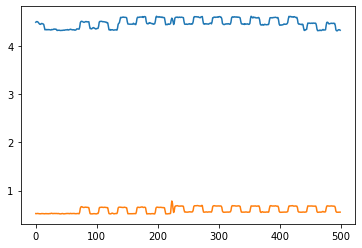

In [5]:
plt.plot(mag_IA1)
plt.plot(mag_IA2)

## Stacking information for each specific PMU
Note: for PMU1 we stacked in info1, for PMU2 we stacked in info2

In [6]:
info1 = numpy.column_stack([mag_VA1,mag_IA1])
info2 = numpy.column_stack([mag_VA2,mag_IA2])

## Adding extra column 
Note: this column will identify the message type. For this specific case M1 and M2

In [7]:
unos = numpy.ones(info1.shape[0]);
unos = unos.reshape(info1.shape[0],1);
label_1 = unos * 1;
label_2 = unos * 2;

In [8]:
info1 = numpy.column_stack([info1, label_1])
info2 = numpy.column_stack([info2, label_2])

## Creating elastic dataset
Note: Each message sample is static. In a window of 10 samples, some sample slots have information from M1 and in some randomly scenarios (based on uniform probability) the M2 is stacked (specifically in Sample 3, or 5, or 7). In other words: every 10 samples we can add samples in sample frame 3 and/or 5 and/or 7.

In [9]:
size_iteration = info1.shape[0];
dataset = info1[:size_iteration,]*0;
index1 = 0;
index2 = 0;
for ii in range(size_iteration):
    
    # TO GET A RANDOM GENERATION OF EVENT 2
    s = numpy.random.uniform(0,1,1)
    if s > 0.5:
        step = 3
    elif s < 0.75:
        step = 5
    else:
        step = 7
        
    # Generation of elastic dataset
    trigger = numpy.remainder(ii,10);
    if trigger==step:
        dataset[ii,] = info2[index2,]
        index2 = index2 + 1; 
    else:
        dataset[ii,] = info1[index1,]
        index1= index1 + 1;  
#dataset.shape

## Splitting dataset between train and test groups

In [10]:
test_data_size = 50;

train_data = dataset[:-test_data_size,]
#train_data = dataset[:-test_data_size,2]
size_train_data = len(train_data)
test_data = dataset[-test_data_size:,]
#test_data = dataset[-test_data_size:,2]
print(len(train_data))
print(len(test_data))

450
50


In [11]:
train_data[:2,:]

array([[1.21929736e+04, 4.49950743e+00, 1.00000000e+00],
       [1.21931064e+04, 4.51186037e+00, 1.00000000e+00]])

## Scaling the dataset between -1 and 1
Note: It is a kind of normalization of the dataset

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
#train_data_normalized = scaler.fit_transform(train_data.reshape(-1,1))

In [13]:
train_data_normalized[:10,:]

array([[ 0.91429312,  0.93932171, -1.        ],
       [ 0.91681173,  0.94533285, -1.        ],
       [ 0.90799659,  0.94590714, -1.        ],
       [ 0.90084818,  0.94382577, -1.        ],
       [ 0.8934405 ,  0.93810909, -1.        ],
       [-0.96925812, -0.99699948,  1.        ],
       [ 0.88994037,  0.93046719, -1.        ],
       [ 0.89277381,  0.92203892, -1.        ],
       [ 0.90073706,  0.91830707, -1.        ],
       [ 0.9032742 ,  0.91883589, -1.        ]])

## Dataset type converstion to Tensors

In [14]:
train_data_normalized_tensor = torch.FloatTensor(train_data_normalized).view(size_train_data,3)
#train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [15]:
train_data_normalized_tensor[:10,:]

tensor([[ 0.9143,  0.9393, -1.0000],
        [ 0.9168,  0.9453, -1.0000],
        [ 0.9080,  0.9459, -1.0000],
        [ 0.9008,  0.9438, -1.0000],
        [ 0.8934,  0.9381, -1.0000],
        [-0.9693, -0.9970,  1.0000],
        [ 0.8899,  0.9305, -1.0000],
        [ 0.8928,  0.9220, -1.0000],
        [ 0.9007,  0.9183, -1.0000],
        [ 0.9033,  0.9188, -1.0000]])

## Very important parameter to choose the Training window size
Note: This define the size of the buffer to be used in the forecasting of the future samples

In [16]:
train_window=20

## *Choosing the information to be used as feature information and Label (target) information to be used during the training session

In [17]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    #L = input_data.shape[0]
    for i in range(L-tw):
        train_seq = input_data[i:i+tw,:3]
        #train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw,:3]
        #train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [18]:
train_inout_seq = create_inout_sequences(train_data_normalized_tensor, train_window)

In [19]:
train_inout_seq[:2]

[(tensor([[ 0.9143,  0.9393, -1.0000],
          [ 0.9168,  0.9453, -1.0000],
          [ 0.9080,  0.9459, -1.0000],
          [ 0.9008,  0.9438, -1.0000],
          [ 0.8934,  0.9381, -1.0000],
          [-0.9693, -0.9970,  1.0000],
          [ 0.8899,  0.9305, -1.0000],
          [ 0.8928,  0.9220, -1.0000],
          [ 0.9007,  0.9183, -1.0000],
          [ 0.9033,  0.9188, -1.0000],
          [ 0.9028,  0.9253, -1.0000],
          [ 0.8967,  0.9272, -1.0000],
          [ 0.8921,  0.9234, -1.0000],
          [ 0.8952,  0.9223, -1.0000],
          [ 0.9036,  0.9172, -1.0000],
          [-0.9695, -0.9977,  1.0000],
          [ 0.9052,  0.8872, -1.0000],
          [ 0.8852,  0.8628, -1.0000],
          [ 0.8886,  0.8650, -1.0000],
          [ 0.8894,  0.8665, -1.0000]]),
  tensor([ 0.8832,  0.8625, -1.0000])),
 (tensor([[ 0.9168,  0.9453, -1.0000],
          [ 0.9080,  0.9459, -1.0000],
          [ 0.9008,  0.9438, -1.0000],
          [ 0.8934,  0.9381, -1.0000],
          [-0.9693, -0

## Deep Learning Architecture
Note: Here we choose the number of hidden layers, size of input dataset, size of output. In this particular case we use the LSTM scheme.

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size=100, output_size=3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(3,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [21]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
print(model)

LSTM(
  (lstm): LSTM(3, 100)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)


## TRAINING SESSION
Note: here we can choose the number of Epochs to be used during training

In [23]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/home/lut/.conda/envs/cnn/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch:   1 loss: 0.02439561
epoch:  26 loss: 0.00221120
epoch:  51 loss: 0.00157986
epoch:  76 loss: 0.00092385
epoch: 101 loss: 0.00647602
epoch: 126 loss: 0.00139532
epoch: 149 loss: 0.0024290304


In [24]:
train_inout_seq[0:2]

[(tensor([[ 0.9143,  0.9393, -1.0000],
          [ 0.9168,  0.9453, -1.0000],
          [ 0.9080,  0.9459, -1.0000],
          [ 0.9008,  0.9438, -1.0000],
          [ 0.8934,  0.9381, -1.0000],
          [-0.9693, -0.9970,  1.0000],
          [ 0.8899,  0.9305, -1.0000],
          [ 0.8928,  0.9220, -1.0000],
          [ 0.9007,  0.9183, -1.0000],
          [ 0.9033,  0.9188, -1.0000],
          [ 0.9028,  0.9253, -1.0000],
          [ 0.8967,  0.9272, -1.0000],
          [ 0.8921,  0.9234, -1.0000],
          [ 0.8952,  0.9223, -1.0000],
          [ 0.9036,  0.9172, -1.0000],
          [-0.9695, -0.9977,  1.0000],
          [ 0.9052,  0.8872, -1.0000],
          [ 0.8852,  0.8628, -1.0000],
          [ 0.8886,  0.8650, -1.0000],
          [ 0.8894,  0.8665, -1.0000]]),
  tensor([ 0.8832,  0.8625, -1.0000])),
 (tensor([[ 0.9168,  0.9453, -1.0000],
          [ 0.9080,  0.9459, -1.0000],
          [ 0.9008,  0.9438, -1.0000],
          [ 0.8934,  0.9381, -1.0000],
          [-0.9693, -0

## Using the Trained Model
Note: based on the trainning model, we evaluate the Neural Network using the same dataset uset for training. Our main target is to generate metrics to quantify the resources that the model will evaluate and compare it with the original resources in each original sample time.

In [25]:
fut_pred = 40
size_prediction = fut_pred
#test_inputs = train_data_normalized[-train_window:].tolist()
#test_inputs = train_data_normalized[-2*train_window:-1*train_window]

test_inputs = train_inout_seq[-size_prediction:]
#test_inputs = train_data_normalized[-size_prediction:,]

#print(test_inputs[0:20])

#train_data1 = train_data[-size_prediction:,]

#train_data_normalizedd = scaler.fit_transform(train_data1)

#train_data_normalized_tensorr = torch.FloatTensor(train_data_normalizedd).view(size_prediction,3)



In [26]:
model.eval()

#train_data_normalized = torch.FloatTensor(train_data_normalized).view(size_train_data,3)
 #train_seq = input_data[i:i+tw,:3]
prediction = [];
for i in range(fut_pred):
    #seq1 = torch.FloatTensor(test_inputs).view(train_window,3)
    seq = test_inputs[i][0]
    #seq = seq1[:train_window,:3]
    #seq = torch.FloatTensor(test_inputs[-size_prediction:,])
    with torch.no_grad():
        model.hidden = (torch.zeros(3, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        #test_inputs.append(model(seq))
        #np.concatenate((test_inputs,model(seq)))
     #   print(test_inputs)
        output = model(seq);
        prediction.append(output[2].item())
        #print(output[2])
        #print(output)
      #  vector_output = [model(seq)[0].item(), model(seq)[1].item(), model(seq)[2].item()]
      #  vec = numpy.array(vector_output).reshape(1,-1)
      #  test_inputs = np.concatenate((test_inputs,vec))
    
      #  print(vector_output)
        #np.concatenate((test_inputs,vector_output))
        
     #   print(test_inputs.shape)
        #model(seq).item()
       # test_inputs.append(model(seq).item())
        #print(model(seq).item())
print(prediction)      

[-0.973568320274353, -0.7177956104278564, -0.763137698173523, -0.8170309662818909, -0.9987043142318726, -0.9771084189414978, -1.0080021619796753, -1.0030542612075806, -0.9926549792289734, -0.9824007749557495, -0.9741482734680176, -0.9687149524688721, -0.966277003288269, -0.9656053781509399, -1.1083990335464478, 0.19995173811912537, -0.5187618732452393, -0.33291468024253845, -0.6286599636077881, -0.9416453838348389, -0.9852437973022461, -0.8916091322898865, -1.0456880331039429, -0.8854954838752747, -1.0754499435424805, -0.3069031536579132, 0.15225616097450256, -0.06639017909765244, -0.5335875749588013, -0.8372198343276978, -0.9479373693466187, -0.8417744636535645, -1.0182613134384155, -0.9326927661895752, -0.9936457872390747, -0.18515124917030334, 0.1678101122379303, -0.48309755325317383, -0.33661970496177673, -0.9628450274467468]


In [27]:
#t=test_inputs[0];
#t[1]


## Re-scaling the predicted information
Note: we rescale the information between -1 and 1. After that we consider a hard decission scheme to get the label values for each Message type.

In [28]:
prediction = numpy.array(prediction)
prediction = prediction.reshape(fut_pred,1)

prediction_full = numpy.column_stack([prediction,prediction, prediction])

#prediction_full_tensor = torch.FloatTensor(prediction_full).view(size_prediction,3)

actual_prediction = scaler.inverse_transform(prediction_full)

for i in range(size_prediction):
    if actual_prediction[i,2]>1.5:
        actual_prediction[i,2] = 2
    else:
        actual_prediction[i,2] = 1
        
prediction = actual_prediction[:,2];
print(prediction)
#for ii in range(10):
#    train_data_normalized[ii,2] = float(prediction[ii])

#actual_predictions = scaler.inverse_transform(train_data_normalized[1:10,])
#print(actual_predictions)

#print(train_data_normalized[0:20,])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1.]


In [29]:
# Real Data
real_data = train_data[-size_prediction:,2]
print(real_data)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.]


## Error analysis 
Note: we compare the difference between predicted information and original information. 1 --> M1 and 2 --> M2

In [30]:
error = np.abs(real_data - prediction)
print(np.sum(error)/size_prediction)
#print(np.sum(error))

0.1


In [31]:
#Slices vs Violation    #Slices vs Resource Utilization

In [32]:
# System utilization evaluation vs ???
# Efficiency using resources
# Evaluation Sections